# **Analyzing WCA Competitors' Relative Performances in Big Cube Events**

Chanoe Andrew Park, Nate Ellis

***

## **Introduction**

Competitively solving a Rubik's cube as quickly as possible, or 'cubing', is not just limited to the typical 3x3 Rubik's cube. Over the years, several different puzzles/events have emerged that competitors have attempted to solve as quickly as possible in an official setting. Four of the most prominent of these puzzles are the 4x4, 5x5, 6x6, and 7x7 Rubik's cubes. Some of these require different techniques in order to be successfully solved. However, though the techniques required to solve may differ, the skillset that makes a good 'cuber' remains the same.

As with other competitions, there may be tradeoffs in mastering some techniques over others. Offensive linemen in football sacrifice speed and agility for size, strikers in soccer sacrifice defensive capabilities for offensive capabilities, etc. In this project, we look to thoroughly explore the correlations between these four large cubes, to perhaps find insight into how performance in one may relate to performance in another.

To learn more about cubing, see https://www.worldcubeassociation.org/about

***

## **Data collection/curation + parsing**
The World Cube Association is the global centralized authority in official competitive Rubik's cube solving. They make the rules of how competitions are held, what puzzles are official, etc. One of their services is that they compile data from any competition that occurs, dating back multiple decades. This will be the data that we use.

In this section, we download rankings from the WCA online database. This database updates daily, so the graphs and data in the project will look different one day compared to another.

In [2]:
import os
import requests
import shutil
import zipfile

data_dir = './WCA_data'
data_zip = f'{data_dir}.zip'

if os.path.isdir(data_dir):
    # Delete the existing data
    shutil.rmtree(data_dir)

if os.path.exists(data_zip):
    # Delete the zipped data
    os.remove(data_zip)

# Get data from WCA
url = 'https://www.worldcubeassociation.org/results/misc/WCA_export.tsv.zip'
r = requests.get(url, stream=True)

with open(data_zip, 'wb') as f:
    f.write(r.content)
            
# Extract zipped data
with zipfile.ZipFile(data_zip, 'r') as zf:
    zf.extractall(data_dir)

Now that we have the required data, we need to restructure the dataset to be useful for our requirements. In this project, we will be looking at the four 'large' cubes: 4x4, 5x5, 6x6, and 7x7. Specifically, we are looking at the performance of different competitors in these four events. So, we get the best average solve timings (how long it took to solve the puzzle) and various rankings from the appropriate table. However, missing data is an issue here. Some competitors might have not competed in some of these events, or possibly none of them at all. How are we supposed to compare how a competitor competes in 4x4 vs 7x7 if they have never competed in 7x7?

To address this, we conglomerate all relevant events into one row instead of having them separated row by row. Then, for any competitor that does not have data for ALL relevant events, we drop their records. This way, we will have a complete dataset with no missing data that we will have to worry about. 

The missing data is missing at random (MAR). Typically this poses a problem for datasets because imputation or replacing MAR data can often be inappropriate. Luckily, our specific premise requires that we have data for ALL relevant events, so in our case, we welcome dropping all of the missing data, as opposed to imputation.

In [3]:
import numpy as np
import pandas as pd

df_avg = pd.read_csv(f'{data_dir}/WCA_export_RanksAverage.tsv', sep='\t', low_memory=False)

# Drop all events that we aren't interested in
df_avg.drop(df_avg[(df_avg.eventId < '444') | (df_avg.eventId > '777')].index, inplace=True)

# Only keep competitors with averages in all events we're interested in (4x4 through 7x7)
tmp = pd.merge(df_avg, df_avg, on='personId', suffixes=('_4', '_5'))
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId')
tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | (tmp.eventId != '666')].index, inplace=True)
tmp = pd.merge(tmp, df_avg, on='personId', suffixes=('_6', '_7'))
df_grouped = tmp.drop(tmp[(tmp.eventId_4 != '444') | (tmp.eventId_5 != '555') | (tmp.eventId_6 != '666') | (tmp.eventId_7 != '777')].index)
df_grouped.reset_index(drop=True, inplace=True)

# Drop eventId columns as not needed anymore
df_grouped.drop(['eventId_4', 'eventId_5', 'eventId_6', 'eventId_7', 
                 'continentRank_4', 'continentRank_5', 'continentRank_6', 'continentRank_7'], 
                axis = 1, inplace=True)

# Fix time scale
df_grouped['best_4'] = np.float64(df_grouped['best_4'] / 100.0)
df_grouped['best_5'] = np.float64(df_grouped['best_5'] / 100.0)
df_grouped['best_6'] = np.float64(df_grouped['best_6'] / 100.0)
df_grouped['best_7'] = np.float64(df_grouped['best_7'] / 100.0)

df_grouped

,personId,best_4,worldRank_4,countryRank_4,best_5,worldRank_5,countryRank_5,best_6,worldRank_6,countryRank_6,best_7,worldRank_7,countryRank_7
0,2012PARK03,19.88,1,1,38.45,1,1,75.63,1,1,106.57,1,1
1,2010WEYE02,21.46,2,1,45.80,8,1,87.19,8,1,154.27,79,3
2,2009ZEMD01,21.57,3,1,42.09,3,1,81.90,5,1,120.63,4,1
3,2016KOLA02,22.00,4,1,39.79,2,1,80.36,3,1,122.46,5,1
4,2012PONC02,23.12,5,2,47.82,12,2,98.55,39,12,158.33,102,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,2008VILL01,118.97,27206,897,182.45,13210,393,330.10,5725,120,557.57,4771,102
4241,2009KIVI01,123.89,27629,130,196.52,13578,75,340.73,5790,43,529.40,4727,41
4242,2011SANG02,139.73,28592,522,223.38,14052,284,541.09,6116,121,782.00,4842,85
4243,2008FERN03,146.66,28870,979,203.17,13733,407,511.27,6103,136,718.00,4831,104


***
## **Data management/representation**

As we are relating four events, we have 4 dimensions of data. A data structure like a KD-Tree or quad-tree can sometimes be effective in visually representing data like this, but it is easiest and most intuitive to create 2-dimensional data and compare it this way. So, we need take the two most similar events and group them. To do this, we create the violin plot below to see which two events are most similar. Not only are 4x4/5x5 and 6x6/7x7 similar in size, they also relate through similar mean, variance, and outliers. You can see that the 4x4/5x5 variance is lower than 6x6/7x7 through the violin plot, and the outliers for 4x4/5x5 are significantly closer to the mean than 6x6/7x7. So, we will couple 4x4 and 5x5 into one group, and 6x6 and 7x7 into another group for future analysis and visualization.

Text(0.5, 1.0, 'Distribution by Event')

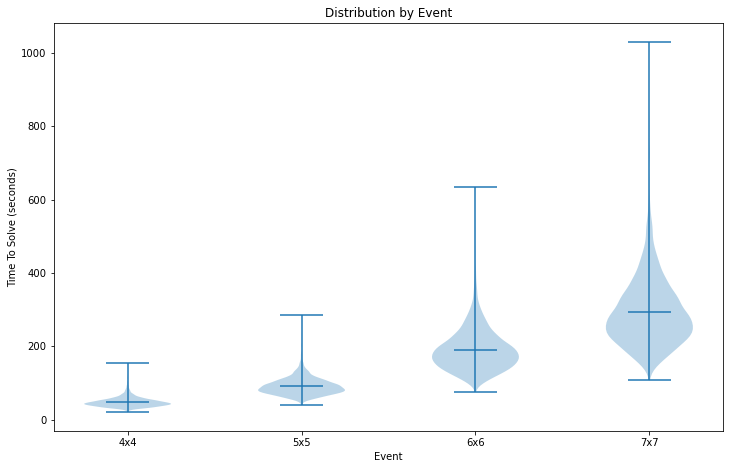

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12,7.5)
event_arr = ['4x4', '5x5', '6x6', '7x7']
time_array = pd.DataFrame().assign(four = df_grouped['best_4'], five= df_grouped['best_5'], six= df_grouped['best_6'],seven= df_grouped['best_7'])
ax.violinplot(time_array,range(0,4,1),showmeans=True)
ax.set_xticks(np.arange(0,4,1), event_arr)
ax.set_xlabel("Event")
ax.set_ylabel("Time To Solve (seconds)")
ax.set_title("Distribution by Event")


There also is the issue about solve times vs. rankings. How should we compare the data? The issue with solve timings is that it takes much less time to solve 4x4 and 5x5 than it does to solve 6x6 and 7x7. We are trying to compare a competitor's performance between the two. Thus, we should standardize performance. If we used solve times to compare, we introduce a new variable into our data. Namely, performance for one event means something different than another. To standardize performance and thus reduce a variable in our data, we use world rankings instead, as a world ranking means the same from one event to another.

After we couple world rankings for the two groups, we create a scatterplot with the axes being the average world rank of the two groups, as well as the regression line. For our graph, 0 is at the top, and rank increases as you get closer to the origin. This is because intuitively it makes more sense for better ranked players to be near the top right. Thus with our plot structure, the higher ranked people in each event are closer to the top right of the plot, and the lower ranked people are closer to the bottom left.

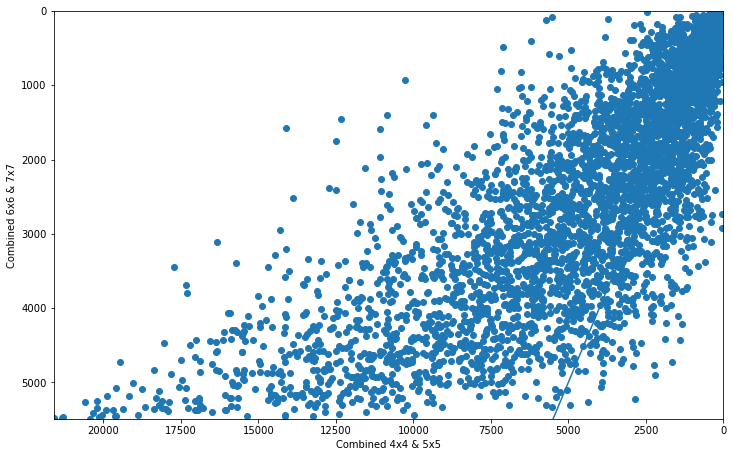

In [10]:
df_shuffled = df_grouped.sample(frac=1).reset_index(drop=True)
combined_45 = (df_shuffled['worldRank_4'] + df_shuffled['worldRank_5']) / 2
combined_67 = (df_shuffled['worldRank_6'] + df_shuffled['worldRank_7']) / 2

plt.rcParams["figure.figsize"] = (12,7.5)

# now plot both limits against eachother
x = combined_45[:]
y = combined_67[:]
plt.scatter(x, y)
plt.xlim(max(x), 0)
plt.ylim(max(y), 0)
plt.plot([max(x), 0], [max(x), 0]) # plots line y = x
plt.xlabel('Combined 4x4 & 5x5')
plt.ylabel('Combined 6x6 & 7x7')
plt.show()

It seems our plot is heavily skewed. As you can see, rankings get down to the 20,000's for 4x4 and 5x5, whereas they only get down to the 5000's for 6x6 and 7x7. After some thinking, we realized that is because it is much harder to solve the largest cubes like 7x7, and thus there is a significantly smaller population of those who do. Therefore, someone in the lowest 10% of 7x7 solvers may only be ranked 4500, whereas someone in the lowest 10% of 4x4 solvers may be ranked 25,000. This skew makes it difficult to analyze the data.

At the start of this project, we limited our dataset to those who have solved all 4 cubes. Therefore, somebody who is 5th in the world in solving 4x4 but has not solved 7x7 is not included in our dataset, which is the reason our data was skewed so heavily. To remedy this, we create internal rankings based on the population in our dataset. So, what it means to be the lowest 10% means the same thing for all events. This is another variable that we can get rid of. Previously, what it meant to be ranked in one event compared to another meant different things, however, with this fix we erase this variable and standardize ranking.

Below we fix this issue:

In [29]:
df_ranked = df_grouped.copy()

for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_4'] = i + 1

df_ranked.sort_values(by='worldRank_5', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_5'] = i + 1

df_ranked.sort_values(by='worldRank_6', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)

for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_6'] = i + 1

df_ranked.sort_values(by='worldRank_7', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
for i, row in df_ranked.iterrows():
    df_ranked.loc[i, 'worldRank_7'] = i + 1

df_ranked.sort_values(by='worldRank_4', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked

,personId,best_4,worldRank_4,countryRank_4,best_5,worldRank_5,countryRank_5,best_6,worldRank_6,countryRank_6,best_7,worldRank_7,countryRank_7
0,2012PARK03,19.88,1,1,38.45,1,1,75.63,1,1,106.57,1,1
1,2010WEYE02,21.46,2,1,45.80,8,1,87.19,8,1,154.27,78,3
2,2009ZEMD01,21.57,3,1,42.09,3,1,81.90,5,1,120.63,4,1
3,2016KOLA02,22.00,4,1,39.79,2,1,80.36,3,1,122.46,5,1
4,2012PONC02,23.12,5,2,47.82,12,2,98.55,39,12,158.33,101,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,2008VILL01,118.97,4241,897,182.45,4226,393,330.10,4151,120,557.57,4194,102
4241,2009KIVI01,123.89,4242,130,196.52,4230,75,340.73,4167,43,529.40,4165,41
4242,2011SANG02,139.73,4243,522,223.38,4239,284,541.09,4243,121,782.00,4239,85
4243,2008FERN03,146.66,4244,979,203.17,4233,407,511.27,4241,136,718.00,4230,104


***
## **Exploratory data analysis**

We have now standardized competitor performance and rank to most effectively visually represent our data. Now, we can look at the graph and extrapolate what it means. Below, we create a scatterplot with our newly standardized data. Then, we add a line of y=x.

Why is y=x important for this data? We are looking at rankings of 4x4 and 5x5 to 6x6 and 7x7. Because we standardized what ranking meant, the units are the same. Both groups only have 4245 ranked competitors. Performance is relative here. So, if you are just as good at 4x4 and 5x5 relative to how good you are at 6x6 and 7x7, your rank is the same in each group. If you are a top 10% performer in 4x4 and 5x5, you may be ranked 425, and if you are a top 10% performer in 6x6 and 7x7, your rank would also be 425. Therefore, the y=x line maps out expected equal performance between the two groups. If you are just as good relative to everyone else in both groups, you will lie on that y=x line. This works both ways, so the further you are from that y=x line, the more 'specialized' you are in one event. Specifically, if you are to the left of the line you are more specialized in 6x6 and 7x7, and if you are to the right of the line you are more specialized in 4x4 and 5x5.

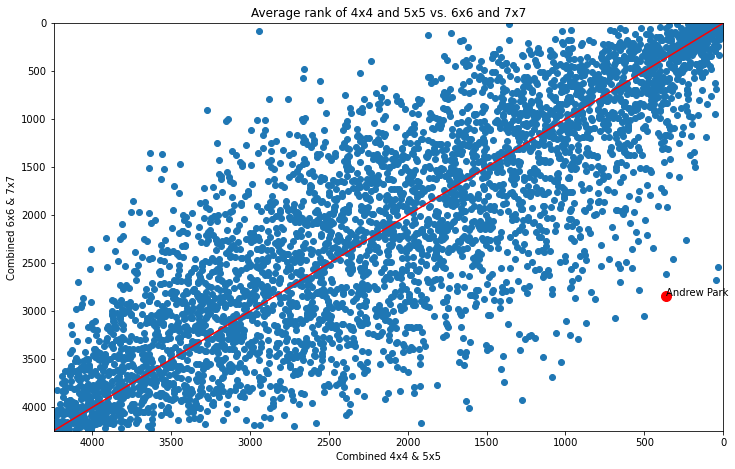

In [32]:
df_shuffled = df_ranked.sample(frac=1).reset_index(drop=True)
combined_45 = (df_shuffled['worldRank_4'] + df_shuffled['worldRank_5']) / 2
combined_67 = (df_shuffled['worldRank_6'] + df_shuffled['worldRank_7']) / 2

plt.rcParams["figure.figsize"] = (12,7.5)

# Plot
x = combined_45[:]
y = combined_67[:]
plt.scatter(x, y)
plt.xlim(max(x), 0)
plt.ylim(max(y), 0)
plt.plot([max(x), 0], [max(y), 0], color='r') # plots line y = x
plt.xlabel('Combined 4x4 & 5x5')
plt.ylabel('Combined 6x6 & 7x7')
plt.title('Average rank of 4x4 and 5x5 vs. 6x6 and 7x7')

# Marking Park in the plot
df_park = df_ranked.loc[df_ranked['personId'] == '2013PARK03']
park_45 = (df_park['worldRank_4'] + df_park['worldRank_5']) / 2
park_67 = (df_park['worldRank_6'] + df_park['worldRank_7']) / 2
plt.plot(park_45, park_67, 'ro', ms=10)
plt.text(park_45, park_67, 'Andrew Park')

plt.show()

Each point here is a person. On the x-axis is their performance for 4x4 and 5x5, and on the y-axis is their performance for 6x6 and 7x7. As you can see, the distribution is fairly linear. However, the variance differs wildly, and people consolidate on the y=x line at both ends of the plot. This means that people who are the best in one group are almost always also the best in the other group, and people who are the worst in one group are almost always the worst in the other group.

However, average-performing competitors see a more 'specialization' effect. Though most still perform relatively the same between the two groups, some average competitors may perform poorly in one group but highly in another. In the plot, one point is colored red and larger than the others. This is Andrew Park, one of the authors of this project. As you can see, Andrew Park is a perfect example of this specialization effect. He is in the top 500 of 4x4 and 5x5 competitors, but only top 3000 of 6x6 and 7x7 performers. As stated earlier, this specialization effect is most prominent closer to the 'middle of the pack'. If you are great or horrible in one group, that tends to be reflected in your ranking in the other.

***
## **Hypothesis testing**

Which one of the group's performances is best at predicting other events? Does group A (4x4 and 5x5) predict 6x6 and 7x7 rankings better or does group B (6x6 and 7x7) predict 4x4 and 5x5 rankings better? 

It is difficult to see which group would be better at predicting. We have already seen the distribution and it is fairly uniform. I hypothesize that the bigger cubes, group B, would be better at predicting smaller cubes because you need to be good to consistently solve bigger cubes. If you are good enough to do that, then your smaller cube times may reflect it.

I used standard linear regression as a prediction model. Firstly, we cannot use something like LDA because these are rankings, not classifications. Thus, any classification function will not properly work. I tested various prediction models, namely SVM with different kernels and C values, but landed on standard linear regression for two reasons. 

1. Dimensionality reduction. SVM has more input parameters than linear regression and thus may be more prone to overfitting.
2. The linear regression algorithm takes almost 0 runtime, whereas SVM took a few minutes

After testing both, I found that SVM was slightly more accurate in terms of percent error. However, the percent error for linear regression was only different by about .2 or less and was also acceptable. I felt the benefits of dimensionality reduction and runtime outweigh the hit to percent error.

Another decision I made was the loss function. I used mean absolute percent error because it effectively measures the loss in our data. Our data is numeric, thus not classifiable, so a binary loss function like a zero-one loss function would not work. Percent error is easy, intuitive, and common, so I used that. Other forms of loss functions to me are just unnecessarily complex, especially for fairly output like ours.

To research different loss functions or prediction models for yourself see:
Loss functions - https://analyticsindiamag.com/loss-functions-in-deep-learning-an-overview/
Prediction models - https://towardsdatascience.com/selecting-the-correct-predictive-modeling-technique-ba459c370d59

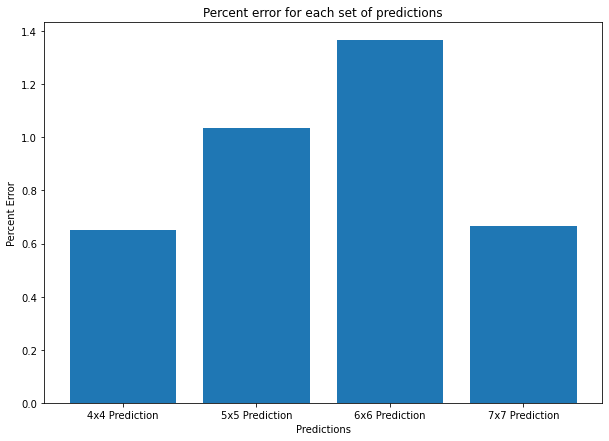

In [33]:
from sklearn.model_selection import train_test_split  
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


groupA_X = pd.DataFrame().assign(four = df_shuffled['worldRank_4'], five= df_shuffled['worldRank_5']) # Create group A using 4x4 and 5x5 ranks
groupB_X = pd.DataFrame().assign(six = df_shuffled['worldRank_6'], seven = df_shuffled['worldRank_7']) # Create group B using 6x6 and 7x7 ranks

prediction_percent_error = []

for rank in ['worldRank_6', 'worldRank_7']: # Use group A to predict through linear regression 6x6 and 7x7 results
    X_train, X_test, y_train, y_test = train_test_split(groupA_X, df_shuffled[rank], test_size=0.4, random_state=0)
    reg = LinearRegression().fit(X_train, y_train)
    prediction_percent_error.append(mean_absolute_percentage_error(y_test, reg.predict(X_test)))
    
for rank in ['worldRank_4', 'worldRank_5']: # Use group B to predict through linear regression 4x4 and 5x5 results
    X_train, X_test, y_train, y_test = train_test_split(groupB_X, df_shuffled[rank], test_size=0.4, random_state=0)
    reg = LinearRegression().fit(X_train, y_train)
    prediction_percent_error.append(mean_absolute_percentage_error(y_test, reg.predict(X_test)))

names = ['4x4 Prediction', '5x5 Prediction', '6x6 Prediction', '7x7 Prediction']
                      
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(names, prediction_percent_error)
plt.xlabel('Predictions')
plt.ylabel('Percent Error')
plt.title('Percent error for each set of predictions')
 
# Show Plot
plt.show()


It seems I was wrong. Because data changes each day, it is almost guaranteed that this graph is different from the one I am writing about. However, it is clear that 5x5 and 6x6 have a higher percent error than 4x4 and 7x7. Still, all 4 are within an acceptable range. 4x4 and 7x7 are similar in percent error whereas the two middle events are slightly higher. My prediction for why this occurs is a form of 'black sheep' effect. 4x4 is the next step up from 3x3 and is often the first puzzle learned after 3x3. The competitors are high in this event thus it is slightly normalized. Then 7x7 is the largest official 'cube' to solve, thus is an obvious choice to specialize in. The other two are just in an awkward limbo of not being special for any particular reason. This is why I think they have a higher percent error, due to a lower competitor base.

***
## **Conclusion (Communication of insights attained)**

Overall, the two key insights we gained from the visualization, prediction, and analysis are that average performers tend to specialize more in one group of events or the other. High performers tend to perform greatly at both events, and low performers tend to perform poorly at poor events, but in the middle people often veer off to one group or the other. Also, it is difficult to predict rankings of 5x5 and 6x6 because they are in an awkward position of few people specializing in them competitively. 7x7 is the largest official cube, and 4x4 is the next step to 3x3, so they see more regular rankings, as opposed to the two awkward middle children.